## DE with voom limma
* rsem expected counts are used

In [1]:
require("edgeR")
require("limma")
library(readr)
require(tximport)
DATA = '../data/'

Loading required package: edgeR
Loading required package: limma
Loading required package: tximport


In [2]:
# from https://github.com/mikelove/tximport/blob/master/vignettes/tximport.md#rsem
labels = c('g1eer4.1', 'g1eer4.2', 'mel.1', 'mel.2', 'eryth.1', 'eryth.2',
           'adrenal.1', 'adrenal.2', 'thymus.1', 'thymus.2')
files <- file.path(DATA, "countsForTximport", paste0(labels, ".tsv"))
names(files) <- labels
txi.rsem <- tximport(files, type = "rsem", reader = read_tsv)

reading in files
1 Parsed with column specification:
cols(
  gene_id = col_character(),
  `transcript_id(s)` = col_character(),
  length = col_double(),
  effective_length = col_double(),
  expected_count = col_double(),
  TPM = col_double(),
  FPKM = col_double(),
  posterior_mean_count = col_double(),
  posterior_standard_deviation_of_count = col_double(),
  pme_TPM = col_double(),
  pme_FPKM = col_double(),
  TPM_ci_lower_bound = col_double(),
  TPM_ci_upper_bound = col_double(),
  FPKM_ci_lower_bound = col_double(),
  FPKM_ci_upper_bound = col_double()
)
2 Parsed with column specification:
cols(
  gene_id = col_character(),
  `transcript_id(s)` = col_character(),
  length = col_double(),
  effective_length = col_double(),
  expected_count = col_double(),
  TPM = col_double(),
  FPKM = col_double(),
  posterior_mean_count = col_double(),
  posterior_standard_deviation_of_count = col_double(),
  pme_TPM = col_double(),
  pme_FPKM = col_double(),
  TPM_ci_lower_bound = col_double(),
 

In [45]:
# rm rows with all low expressed genes
# 50 and 10 are pretty good
# gtr 10 in at least two samples
# isexpr <- rowSums(cpm(x) > 10) >= 2
# 5 and 2 puts them very close
isexpr <- rowSums(txi.rsem$counts > 5) > 1
useM = txi.rsem$counts[isexpr,]

#flag = apply(txi.rsem$counts, 1, max)>5
#useMpre = txi.rsem$counts[flag,]
#flag = apply(useMpre, 1, min)>2
#useM = useMpre[flag,]

In [46]:
dim(txi.rsem$counts)

[1] 30433    10

In [47]:
dim(useM)

[1] 19018    10

In [ ]:
# abundance is fpkm
# counts is expected count
# need to filter low!

In [19]:
log(300+.5, 2)

[1] 8.231221

In [48]:
y <- DGEList(counts=as.matrix(useM), genes=rownames(useM))
y <- calcNormFactors(y)

In [49]:
# condition = factor(rep(c("A", "B"), each = 3)))
m=c('g1eer4','g1eer4', 'mel', 'mel','eryth', 'eryth', 'adrenal', 'adrenal', 'thymus', 'thymus')
design <- model.matrix(~factor(m))
print(design)

   (Intercept) factor(m)eryth factor(m)g1eer4 factor(m)mel factor(m)thymus
1            1              0               1            0               0
2            1              0               1            0               0
3            1              0               0            1               0
4            1              0               0            1               0
5            1              1               0            0               0
6            1              1               0            0               0
7            1              0               0            0               0
8            1              0               0            0               0
9            1              0               0            0               1
10           1              0               0            0               1
attr(,"assign")
[1] 0 1 1 1 1
attr(,"contrasts")
attr(,"contrasts")$`factor(m)`
[1] "contr.treatment"



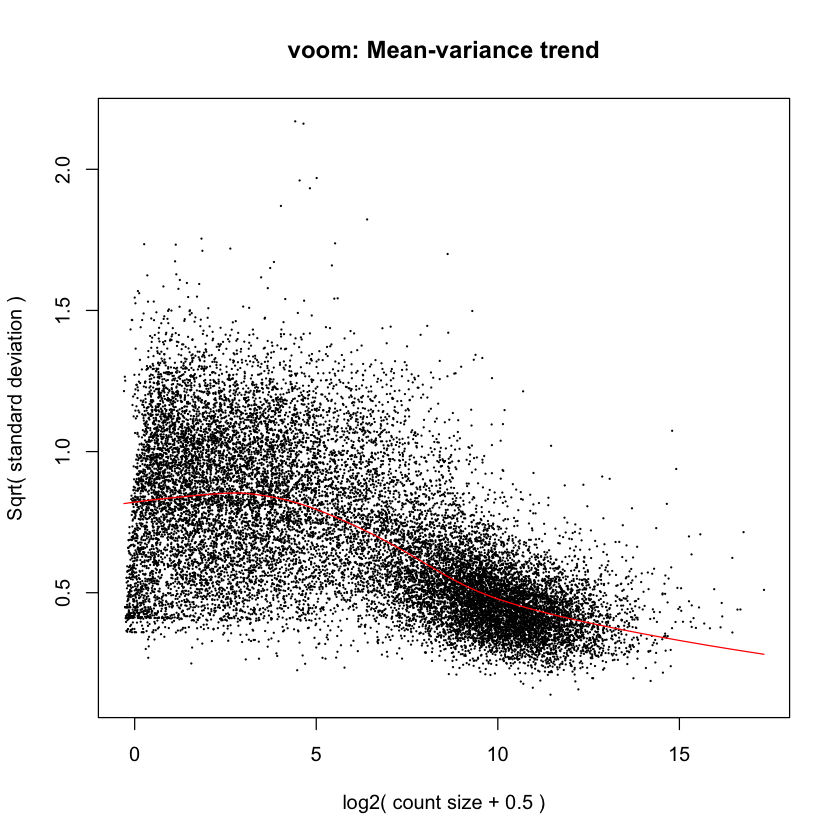

In [50]:
#targets = data.frame()
#colnames()
#design <- model.matrix(~as.factor(labels))
#print(design)
v <- voom(y, design, plot=TRUE);
voomData <- v$E

In [51]:
#Run linear fit and Create the contrast
design <- model.matrix(~0+factor(m))
colnames(design) <- c('g1eer4', 'mel', 'eryth', 'adrenal', 'thymus')
fit <- lmFit(voomData, design)

In [52]:
contrast.matrix <- makeContrasts(g1eVsOther="g1eer4-mel-eryth",
                                 melVsOther="mel-g1eer4-eryth",
                                 erythVsOther="eryth-g1eer4-mel",
                                 g1eVsMel="g1eer4-mel",
                                 levels=design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

#Okay now combine all into one result data frame
#myComps <- colnames(fit2$contrasts);

In [53]:
myComps <- colnames(fit2$contrasts)
output <- topTable(fit2, number=60000)
genOutput <- output[,c(c(1:length(myComps)), grep("P.Value", colnames(output)))]
colnames(genOutput)[1:length(myComps)] <- myComps;
tmpOut <- topTable(fit2, number=60000, 1)[,c("logFC", "P.Value", "adj.P.Val")];
colnames(tmpOut) <- paste(myComps[1], colnames(tmpOut), sep="_");
IndComp <- tmpOut;

    for(i in 2:length(myComps))
    {
    tmpOut <- topTable(fit2, number=60000, i)[,c("logFC", "P.Value", "adj.P.Val")];
    tmpOut <- tmpOut[rownames(IndComp),];
    colnames(tmpOut) <- paste(myComps[i], colnames(tmpOut), sep="_");
    IndComp <- cbind(IndComp, tmpOut);
    }

AllResult <- list(genOutput, IndComp, voomData, design, myComps);

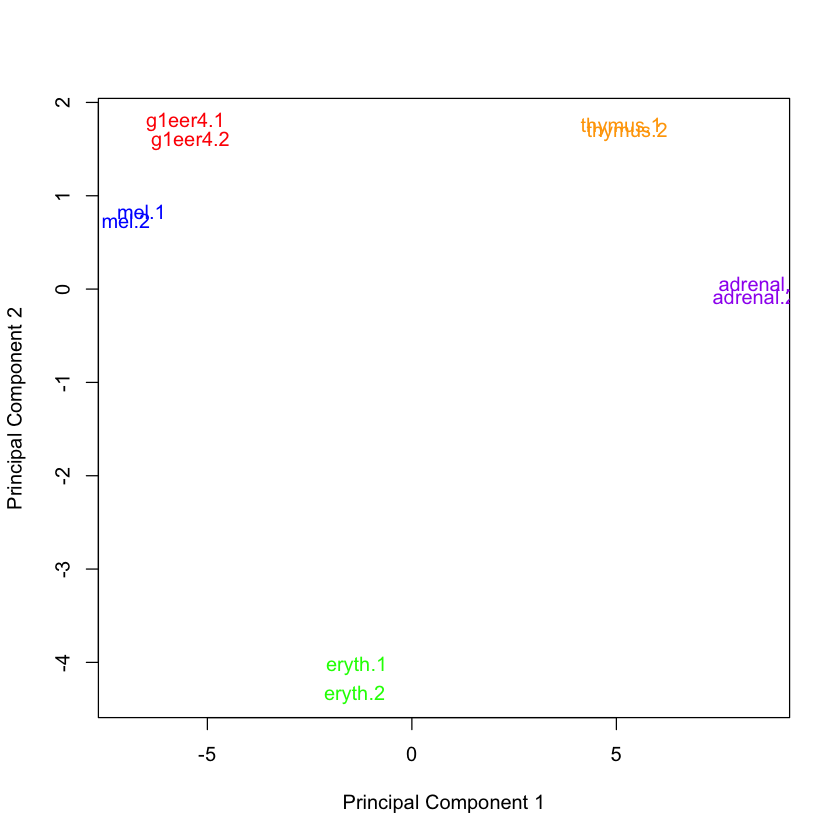

In [54]:
mycol=c("red", "red", "blue", "blue", "green", "green", 'purple', 'purple', 'orange', 'orange')
plotMDS(v, top=50, labels=labels, col=mycol, gene.selection="common")

In [55]:
names(AllResult) <- c("effectPval", "fullResult", "voomMatrix", "design", "comparison")

In [58]:
l = AllResult$fullResult[ AllResult$fullResult['g1eVsMel_adj.P.Val']<0.01
                          & abs(AllResult$fullResult['g1eVsMel_logFC'])>1, ]

In [59]:
dim(l)

[1] 11962    12